In [34]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from matplotlib import pyplot as plt

In [35]:
# Baca dataset
excel = pd.read_excel('dataset.xlsx', sheet_name='Tester')
df = pd.DataFrame(excel)
df

,KPU,PPU,PPM,PM2,LNG,LND,PM,Jurusan
0,507.0,509.0,602.0,480.0,475.0,630.0,386.0,Analisis Kimia
1,589.0,604.0,613.0,440.0,525.0,540.0,462.0,Fisika
2,614.0,528.0,505.0,533.0,576.0,426.0,738.0,teknologi manajemen pembenihan ikan
3,624.0,710.0,569.0,460.0,558.0,542.0,484.0,Keperawatan
4,583.0,729.0,535.0,410.0,538.0,537.0,620.0,Agroteknologi
...,...,...,...,...,...,...,...,...
192,759.0,680.0,605.0,911.0,713.0,743.0,951.0,Teknik Biomedis
193,750.0,738.0,708.0,866.0,715.0,744.0,864.0,Sekolah Teknik Elektro dan Informatika - Rekayasa
194,695.0,743.0,717.0,952.0,747.0,651.0,889.0,Pendidikan Dokter
195,742.0,744.0,731.0,867.0,765.0,829.0,804.0,Kedokteran Gigi


In [36]:
# Definisi rentang nilai dan fungsi keanggotaan untuk setiap variabel
variables = {
    'KPU': {'low': 319, 'mid': 500, 'high': 800},
    'PPU': {'low': 319, 'mid': 500, 'high': 800},
    'PPM': {'low': 319, 'mid': 500, 'high': 800},
    'PM2': {'low': 319, 'mid': 500, 'high': 800},
    'LNG': {'low': 319, 'mid': 500, 'high': 800},
    'LND': {'low': 319, 'mid': 500, 'high': 800},
    'PM': {'low': 319, 'mid': 500, 'high': 800}
}

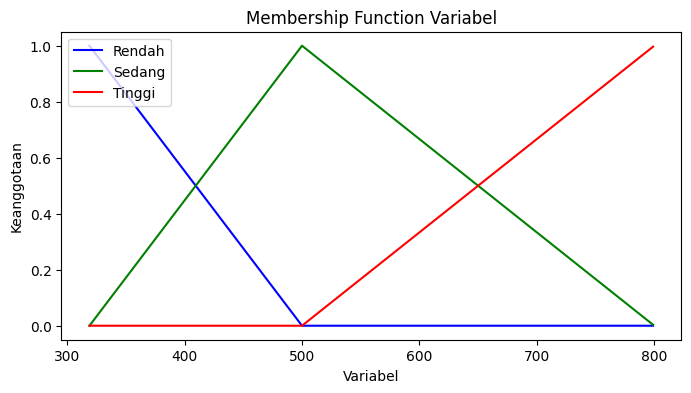

In [60]:
low = 319
mid = 500
high = 800
# kpu = ctrl.Antecedent(np.arange(min_kpu, max_kpu, 1), 'kpu')
x_kpu = np.arange(low, high, 1)
# Definisikan fungsi keanggotaan untuk setiap kategori
rendah = fuzz.trimf(x_kpu, [low, low,mid])
normal = fuzz.trimf(x_kpu, [low, mid, high])
tinggi = fuzz.trimf(x_kpu, [mid, high,high])

plt.figure(figsize=(8, 4))
plt.plot(x_kpu, rendah, 'b', label='Rendah')
plt.plot(x_kpu, normal, 'g', label='Sedang')
plt.plot(x_kpu, tinggi, 'r', label='Tinggi')
plt.title('Membership Function Variabel')
plt.xlabel('Variabel')
plt.ylabel('Keanggotaan')
plt.legend(loc='upper left')
plt.show()

In [37]:
# Fungsi untuk fuzzifikasi nilai
def fuzzifikasi_nilai(nilai, var):
    low = variables[var]['low']
    mid = variables[var]['mid']
    high = variables[var]['high']
    x = np.arange(low, high, 1)
    rendah = fuzz.trimf(x, [low, low, mid])
    normal = fuzz.trimf(x, [low, mid, high])
    tinggi = fuzz.trimf(x, [mid, high, high])
    derajat_rendah = fuzz.interp_membership(x, rendah, nilai)
    derajat_normal = fuzz.interp_membership(x, normal, nilai)
    derajat_tinggi = fuzz.interp_membership(x, tinggi, nilai)
    return derajat_rendah, derajat_normal, derajat_tinggi

# Dataframe untuk menyimpan hasil fuzzifikasi
fuzzifikasi_df = pd.DataFrame(columns=['KPU', 'PPU', 'PPM', 'PM2', 'LNG', 'LND', 'PM'])

In [61]:
# Melakukan fuzzifikasi untuk setiap variabel dan menyimpan hasilnya dalam dataframe
for idx, row in df.iterrows():
    hasil_fuzzifikasi = []
    for var in variables:
        nilai = row[var]
        hasil_rendah, hasil_normal, hasil_tinggi = fuzzifikasi_nilai(nilai, var)
        nilai_defuzzifikasi = np.argmax([hasil_rendah, hasil_normal, hasil_tinggi])
        hasil_fuzzifikasi.append(nilai_defuzzifikasi)
    fuzzifikasi_df.loc[idx] = hasil_fuzzifikasi
    
# Mapping dictionary
mapping = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}

# Replace values in 'category' column
fuzzifikasi_df['PM'] = fuzzifikasi_df['PM'].replace(mapping)
fuzzifikasi_df['PM']

[2, 2, 2, 0, 2, 2, 0]

In [39]:
def kategori_tps(kpu, ppu, ppm, pm2, rule_base_df):
    # Mengecek kondisi jika ada 3 atau lebih nilai 0
    if [kpu, ppu, ppm, pm2].count(0) >= 3:
        return 'Tidak Layak'

    # Mengecek kondisi jika ada lebih dari 2 nilai 2
    if [kpu, ppu, ppm, pm2].count(2) > 2:
        return 'Sangat Bagus'

    # Mencari aturan yang sesuai dalam rule base (dataset.xlsx)
    condition = (rule_base_df['KPU'] == kpu) & (rule_base_df['PPU'] == ppu) & (
        rule_base_df['PPM'] == ppm) & (rule_base_df['PM2'] == pm2)
    matches = rule_base_df[condition]

    # Jika ada aturan yang cocok, kembalikan nilai OUTPUT dari aturan pertama yang cocok
    if not matches.empty:
        return matches.iloc[0]['OUTPUT']
    else:
        return 'Cek lagi'  # Jika tidak ada aturan yang cocok, kembalikan 'Cek lagi'

In [63]:
tps_input = fuzzifikasi_df[['KPU', 'PPU', 'PPM', 'PM2']]
rule_base_path = 'dataset.xlsx'
rule_base_sheet = 'Rule Base - TPS'
df_rule_base = pd.read_excel(rule_base_path, sheet_name=rule_base_sheet)
# List untuk menyimpan hasil kategori_tps
results = []

 # Iterasi melalui setiap baris df_input dan cetak hasil kategori_tps
for index, row in tps_input.iterrows():
        kpu = row['KPU']
        ppu = row['PPU']
        ppm = row['PPM']
        pm2 = row['PM2']
        output = kategori_tps(kpu, ppu, ppm, pm2, df_rule_base)
        print(f'{index} - {output}')
        results.append(output)
tps_input['TPS'] = results

0 - Bagus
1 - Bagus
2 - Bagus
3 - Baca Bagus
4 - Baca Bagus
5 - Nalar Bagus
6 - Nalar Bagus
7 - Hitung Bagus
8 - Nalar Bagus
9 - Bagus
10 - Baca Bagus
11 - Bagus
12 - Bagus
13 - Nalar Bagus
14 - Sangat Bagus
15 - Bagus
16 - Bagus
17 - Baca Bagus
18 - Baca Bagus
19 - Baca Bagus
20 - Baca Bagus
21 - Hitung Bagus
22 - Hitung Bagus
23 - Baca Bagus
24 - Hitung Bagus
25 - Hitung Bagus
26 - Hitung Bagus
27 - Baca Bagus
28 - Baca Bagus
29 - Baca Bagus
30 - Hitung Bagus
31 - Nalar Bagus
32 - Hitung Bagus
33 - Baca Bagus
34 - Hitung Bagus
35 - Nalar Bagus
36 - Hitung Bagus
37 - Baca Bagus
38 - Nalar Bagus
39 - Baca Bagus
40 - Baca Bagus
41 - Nalar Bagus
42 - Nalar Bagus
43 - Baca Bagus
44 - Baca Bagus
45 - Nalar Bagus
46 - Sangat Bagus
47 - Sangat Bagus
48 - Nalar Bagus
49 - Hitung Bagus
50 - Nalar Bagus
51 - Sangat Bagus
52 - Nalar Bagus
53 - Sangat Bagus
54 - Biasa
55 - Hitung Bagus
56 - Hitung Bagus
57 - Biasa
58 - Baca Bagus
59 - Sangat Bagus
60 - Nalar Bagus
61 - Hitung Bagus
62 - Sangat Ba

C:\Users\fzrah\AppData\Local\Temp\ipykernel_18036\2170095031.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tps_input['TPS'] = results


In [41]:
tps_input
TPS_VALUE = tps_input['TPS']
TPS_VALUE

0             Bagus
1             Bagus
2             Bagus
3        Baca Bagus
4        Baca Bagus
           ...     
192      Baca Bagus
193    Sangat Bagus
194    Sangat Bagus
195    Sangat Bagus
196    Sangat Bagus
Name: TPS, Length: 197, dtype: object

In [42]:
def kategori_lb(lng, lnd, rule_base_df):

    # Mencari aturan yang sesuai dalam rule base (dataset.xlsx)
    condition = (rule_base_df['LNG'] == lng) & (rule_base_df['LND'] == lnd)
    matches = rule_base_df[condition]
    # Jika ada aturan yang cocok, kembalikan nilai OUTPUT dari aturan pertama yang cocok
    if not matches.empty:
        return matches.iloc[0]['OUTPUT']
    else:
        return 'Cek lagi'  # Jika tidak ada aturan yang cocok, kembalikan 'Cek lagi'


In [43]:
lb_input = fuzzifikasi_df[['LNG', 'LND']]
rule_base_path = 'dataset.xlsx'
rule_base_sheet = 'Rule Base - LB'
df_rule_base = pd.read_excel(rule_base_path, sheet_name=rule_base_sheet)
# List untuk menyimpan hasil kategori_tps
results = []

 # Iterasi melalui setiap baris df_input dan cetak hasil kategori_tps
for index, row in lb_input.iterrows():
        lng = row['LNG']
        lnd = row['LND']
        output = kategori_lb(lng, lnd, df_rule_base)
        print(f'{index} - {output}')
        results.append(output)
lb_input['LB'] = results

0 - Sedang
1 - Sedang
2 - Sedang
3 - Sedang
4 - Sedang
5 - Sedang
6 - Sedang
7 - Sedang
8 - Sedang
9 - Sedang
10 - Sedang
11 - Sedang
12 - Sedang
13 - Sedang
14 - Sedang
15 - Tinggi
16 - Sedang
17 - Sedang
18 - Tinggi
19 - Tinggi
20 - Sedang
21 - Sedang
22 - Sedang
23 - Tinggi
24 - Sedang
25 - Sedang
26 - Sedang
27 - Sedang
28 - Sedang
29 - Sedang
30 - Tinggi
31 - Sedang
32 - Tinggi
33 - Sedang
34 - Tinggi
35 - Sedang
36 - Sedang
37 - Tinggi
38 - Tinggi
39 - Tinggi
40 - Sedang
41 - Tinggi
42 - Sedang
43 - Tinggi
44 - Tinggi
45 - Tinggi
46 - Tinggi
47 - Tinggi
48 - Tinggi
49 - Sedang
50 - Sedang
51 - Sedang
52 - Tinggi
53 - Sedang
54 - Tinggi
55 - Sedang
56 - Tinggi
57 - Sedang
58 - Tinggi
59 - Sedang
60 - Tinggi
61 - Sedang
62 - Sedang
63 - Tinggi
64 - Tinggi
65 - Tinggi
66 - Sedang
67 - Sedang
68 - Tinggi
69 - Tinggi
70 - Tinggi
71 - Sedang
72 - Sedang
73 - Tinggi
74 - Tinggi
75 - Tinggi
76 - Tinggi
77 - Tinggi
78 - Tinggi
79 - Tinggi
80 - Sedang
81 - Tinggi
82 - Sedang
83 - Tinggi
84

C:\Users\fzrah\AppData\Local\Temp\ipykernel_18036\1709919929.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lb_input['LB'] = results


In [44]:
LB_VALUE = lb_input['LB']
LB_VALUE

0      Sedang
1      Sedang
2      Sedang
3      Sedang
4      Sedang
        ...  
192    Tinggi
193    Tinggi
194    Tinggi
195    Sedang
196    Tinggi
Name: LB, Length: 197, dtype: object

In [45]:
fuzzifikasi_df['PM']

0      Rendah
1      Sedang
2      Tinggi
3      Sedang
4      Sedang
        ...  
192    Rendah
193    Rendah
194    Rendah
195    Rendah
196    Rendah
Name: PM, Length: 197, dtype: object

In [46]:
selected_columns = [TPS_VALUE, LB_VALUE, fuzzifikasi_df['PM']]
new_df = pd.DataFrame(selected_columns).transpose()
new_df

,TPS,LB,PM
0,Bagus,Sedang,Rendah
1,Bagus,Sedang,Sedang
2,Bagus,Sedang,Tinggi
3,Baca Bagus,Sedang,Sedang
4,Baca Bagus,Sedang,Sedang
...,...,...,...
192,Baca Bagus,Tinggi,Rendah
193,Sangat Bagus,Tinggi,Rendah
194,Sangat Bagus,Tinggi,Rendah
195,Sangat Bagus,Sedang,Rendah


Expert System

In [53]:
def kategori_final(tps, lb, pm, rule_base_df):
    # Mencari aturan yang sesuai dalam rule base
    condition = (rule_base_df['TPS'] == tps) & (
        rule_base_df['LB'] == lb) & (rule_base_df['PM'] == pm)
    matches = rule_base_df[condition]

    # Jika ada aturan yang cocok, kembalikan nilai TARGET dari aturan pertama yang cocok
    if not matches.empty:
        return matches.iloc[0]['JURUSAN']
    else:
        return 'Cek lagi'  # Jika tidak ada aturan yang cocok, kembalikan 'Cek lagi'

In [54]:
rule_base_path = 'dataset.xlsx'
rule_base_df = pd.read_excel(
        rule_base_path, sheet_name='Rule Base - Final')
# List untuk menyimpan hasil kategori_tps
results = []
input_data = []
for idx, row in new_df.iterrows() : 
 tps = row['TPS']
 lb = row['LB']
 pm = row['PM']
 input_data.append((tps,lb,pm))

In [55]:
for tps,lb,pm, in input_data : 
 output = kategori_final(tps,lb,pm,rule_base_df)
 results.append((tps, lb, pm, output))
 print(f'TPS: {tps}, LB: {lb}, PM: {pm} -> TARGET: {output}')

TPS: Bagus, LB: Sedang, PM: Rendah -> TARGET: Ilmu Medis dan Keperawatan
TPS: Bagus, LB: Sedang, PM: Sedang -> TARGET: Pertanian, Peternakan, Kehutanan
TPS: Bagus, LB: Sedang, PM: Tinggi -> TARGET: Ilmu Komputer dan Teknologi Informasi
TPS: Baca Bagus, LB: Sedang, PM: Sedang -> TARGET: Teknik
TPS: Baca Bagus, LB: Sedang, PM: Sedang -> TARGET: Teknik
TPS: Nalar Bagus, LB: Sedang, PM: Sedang -> TARGET: Kedokteran dan Kedokteran Hewan
TPS: Nalar Bagus, LB: Sedang, PM: Sedang -> TARGET: Kedokteran dan Kedokteran Hewan
TPS: Hitung Bagus, LB: Sedang, PM: Sedang -> TARGET: Teknik
TPS: Nalar Bagus, LB: Sedang, PM: Tinggi -> TARGET: Kedokteran dan Kedokteran Hewan
TPS: Bagus, LB: Sedang, PM: Tinggi -> TARGET: Ilmu Komputer dan Teknologi Informasi
TPS: Baca Bagus, LB: Sedang, PM: Sedang -> TARGET: Teknik
TPS: Bagus, LB: Sedang, PM: Tinggi -> TARGET: Ilmu Komputer dan Teknologi Informasi
TPS: Bagus, LB: Sedang, PM: Sedang -> TARGET: Pertanian, Peternakan, Kehutanan
TPS: Nalar Bagus, LB: Sedang, P